In [32]:
#Importing Necessary Libraries
import json 
import os
import csv
import json
import sqlite3
import pydot
import numpy as np 
import pandas as pd
import tensorflow as tf
import seaborn as sns
import sqlite3
from pathlib import Path
from typing import Dict, Text
import matplotlib.pyplot as plt
from collections import defaultdict
import tensorflow.keras as keras
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from operator import itemgetter
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
%matplotlib inline


In [2]:
np.random.seed=2022

## Database Operation Functions


In [3]:
def connect(path):
    con=sqlite3.connect(path)
    return con


def createQuery(query,connection):
    try:
        connection.cursor().execute(query)
        print('Table Created')
    except Exception as e:
        print('Exception',e)
        


#Function to perform get queries
def getQuery(query,connection):
    try:
        result=connection.cursor().execute(query)
        print('Query Executed')
        return result.fetchall()
    except Exception as e:
        print('Exception',e)

        
#Function to convert query(which comes in as a list of tuples to DataFrame)
def toDf(res,cols):
    try:
        return pd.DataFrame(res,columns=cols)
    except Exception as e:
        print(f'The DataFrame cannot be created because of this error: {e}')

        
#Generating Schema for Tables
        
def generateSchema(tableName,df):
    schema=f'create table if not exists {tableName}('
    cols=df.columns
    dataType={'int64':'int','float64':'int','object':'varchar(100)','bool':'boolean'}
    for i in range(len(cols)):
        name=''.join(cols[i].split(' '))
        if name.startswith('Date'):
            definition=f'{name} DATE,'
            schema+=definition
            continue
        if name.startswith('Yea'):
            definition=f'{name} YEAR,'
            schema+=definition
            continue
            
        if i!=len(cols)-1:
            definition=f'{name} {dataType[str(df[cols[i]].dtype)]}, '
            schema+=definition
        else:
            definition=f'{name} {dataType[str(df[cols[i]].dtype)]})'
            schema+=definition
    return schema

#Function Transformed

def getQuery(query,connection,cols):
    try:
        result=connection.cursor().execute(query)
        print('Query Executed')
        return toDf(result.fetchall(),cols)
    except Exception as e:
        print('Exception',e)


## Creation of Database

In [4]:
# Creating csv files from JSON

In [5]:
#Reads JSON Files and convert them to Csv[1]

def build_csv_dataset(
    n_lines, 
    in_file_name='yelp_academic_dataset_review.json', 
    out_file_name='reviews.csv', 
    fields=('user_id', 'business_id', 'stars', 'text')
):
    path = Path.cwd().parent / 'input' / 'yelp-dataset' / in_file_name
    line_gen = gen(path)
    
    with open(out_file_name, 'w') as f:
        csv_writer = csv.writer(f)
        
        i = 0
        for line in line_gen:
            if i == 0:
                csv_writer.writerow(fields)
                i += 1
            row = {k: line[k] for k in line.keys() if k in fields}.values()
            csv_writer.writerow(row)
            i += 1
            
            if i % 1000 == 0 :
                print(f'Processed {i}/{n_lines} lines', end="\r")

            if i == n_lines:
                break
        print('all done!')  
        
#To read each line
def gen(file_name):
    with open(file_name) as fh:
        line = fh.readline()
        while line:
            yield json.loads(line)
            line = fh.readline()
        


In [6]:
#Copy dummy db from input to working in kaggle to get write access
#We use testsqllite Database at kaggle to get the empty database
!sudo cp /kaggle/input/testsqlitedatabase/database.db /kaggle/working/database.db

In [7]:
# Connect To the database
connection=connect('database.db')

In [8]:
# Creating Tables
n_lines = 1_000_000_000

build_csv_dataset(
    n_lines=n_lines, 
    in_file_name='yelp_academic_dataset_business.json', 
    out_file_name='business.csv', 
    fields=('business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours')
)

# The abpve is an example of the csv creation, where you pass n_lines the maximum number of lines to read from json and the file name, output csv name 
#and the fields that should be considered while writing

all done! 160000/1000000000 lines


In [10]:
# CSV to SQL tabel
business=pd.read_csv('business.csv')
query=generateSchema('business',business)
print('The schema created for table business is:\n',query)
createQuery(query,connection)

#To only choose restraunts we create a mask [2]
temp = business.categories.str.contains('Restaurant', na=False) | business.categories.str.contains('Food', na=False)
business = business[temp].reset_index()
business.drop('index',axis=1,inplace=True)

business.to_sql('business',connection,if_exists='append',index=False,method=None)

The schema created for table business is:
 create table if not exists business(business_id varchar(100), name varchar(100), address varchar(100), city varchar(100), state varchar(100), postal_code varchar(100), latitude int, longitude int, stars int, review_count int, is_open int, attributes varchar(100), categories varchar(100), hours varchar(100))
Table Created


We repeat this process for every file in the yelp-dataset except tips. We refrain from running other cells due to their computational complexities and present this as an example.

Finally we get YelpDB database cosnisting of users, reviews, checkin and business tables resulting in a 11 GB database, we used database to have a final working version ready for the team and it also decreases the load time.

In [11]:
#We now change our connection to the newly created database.
connection=connect('../input/yelpdb/database.db')

In [12]:
# We perform an inner join on the buisness and reviews table to get all the users that rated a buisness
buisnessJoined=getQuery('select a.business_id, b.user_id, b.stars from business a INNER JOIN reviews b where a.business_id=b.business_id',connection,['business_id','user_id','stars'])

Query Executed


In [13]:
#Having a look at our data 
buisnessJoined.head()

,business_id,user_id,stars
0,6iYb2HFDywm3zjuRg0shjw,-8F13O-CmxEvVuclE8o0lQ,3
1,6iYb2HFDywm3zjuRg0shjw,-B9h9P456KrNogBrwv7vXQ,4
2,6iYb2HFDywm3zjuRg0shjw,-VSlrMM1cKRs7_KMmyTKew,5
3,6iYb2HFDywm3zjuRg0shjw,-qiFxzpUBOnZ28l_KMgTXw,5
4,6iYb2HFDywm3zjuRg0shjw,0KhRPd66BZGHCtsb9mGh_g,5


## Data Preprocessing [3]

In [19]:
# To get embedding we will require a unique and continious index or ids hence we use the following Transformations

#Taking Unique Users 
users = buisnessJoined.user_id.unique()
restraunts = buisnessJoined.business_id.unique()

# Creating a Reindexing Dictionary
userid2idx = {o:i for i,o in enumerate(users)}
restraunts2idx = {o:i for i,o in enumerate(restraunts)}

#Reindexing the Dataframe
buisnessJoined['business_id'] = buisnessJoined.business_id.apply(lambda x: restraunts2idx[x])
buisnessJoined['user_id'] = buisnessJoined.user_id.apply(lambda x: userid2idx[x])

#Getting Unique users which will give the number of embeddings required
nusers = buisnessJoined.user_id.nunique()
nrestraunts = buisnessJoined.business_id.nunique()
print(f'The number of Unique Users and Restraunts are {nusers}, {nrestraunts} respectively')


#Splitting Our Data into train and validation data
train_indices, val_indices = train_test_split(range(buisnessJoined.shape[0]), train_size=0.8)
trdf = buisnessJoined.iloc[train_indices]
val_indices,test_indices=train_test_split(range(valdf.shape[0]),train_size=0.5)
valdf = buisnessJoined.iloc[val_indices]
testdf=buisnessJoined.iloc[test_indices]
print(f'The train and validation dataset shapes are {trdf.shape}, {valdf.shape} respectively')
print(f'The test dataset shape is {testdf.shape}')

The number of Unique Users and Restraunts are 1617955, 63915 respectively
The train and validation dataset shapes are (9748798, 3), (1218600, 3) respectively
The test dataset shape is (1218600, 3)


## Model Creation [3]

In [26]:
#This Function will be used to create user and item(restraunts) biases
def create_bias(name, inp, n_in, reg):
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flattened')(x)

#This function will be used to extract the latent features of user and items which will give us the residuals upon the dot product
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

#We define latent space dimensions and regularization params
L = 45
REG=8e-4

# We obtain the input placeholders as well as the embedding matrix for user and item
user_input, uLmat = embedding_input('user_input', nusers, L, REG)
restraunts_input, rLmat = embedding_input('restraunts_input', nrestraunts, L, REG)

# We now obtain the user and item bias
user_bias = create_bias('user_bias', user_input, nusers, REG)
restraunts_bias = create_bias('movie_bias', restraunts_input, nrestraunts, REG)

#by dot product we generate our residual matrix
residual = Dot(axes=2, name="residual")([uLmat, rLmat])

#Also to use in regression we flatten this matrix to an array 
residflat = Flatten(name="residual_flat")(residual)

#Regression is the sum of biases and residuals
regression = Add(name="regression")([user_bias, restraunts_bias, residflat])

#Next We make the sigmoid activation to contain our output with in a range of 0-5
def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low
    return custom_sigmoid
cs = sigmoid_maker(0, 5.5)

# We now blend the activation in our model
output = Activation(cs, name="Sigmoid_Range")(regression)

#We compile our model and take Adam as the preferred optimizer and mean squared error as the loss 
model = Model([user_input, restraunts_input], output)
model.compile(Adam(0.005), loss='mse')

In [16]:
#Looking at models flow and parameters
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
restraunts_input (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_factor (Embedding)         (None, 1, 45)        72807975    user_input[0][0]                 
__________________________________________________________________________________________________
restraunts_factor (Embedding)   (None, 1, 45)        2876175     restraunts_input[0][0]           
______________________________________________________________________________________________

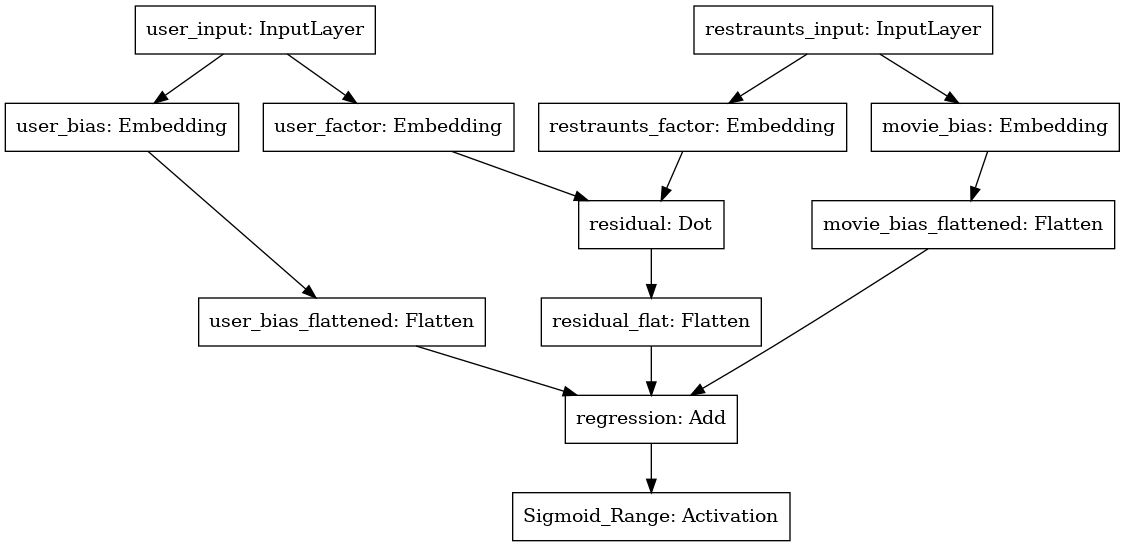

In [17]:
tf.keras.utils.plot_model(model)

In [27]:
#training our model 
history=model.fit([trdf.user_id, trdf.business_id], trdf.stars, batch_size=1024, epochs=3, validation_data=([valdf.user_id, valdf.business_id], valdf.stars))

Epoch 1/3
9521/9521 [==============================] - 177s 18ms/step - loss: 1.5310 - val_loss: 1.1927
Epoch 2/3
9521/9521 [==============================] - 175s 18ms/step - loss: 1.1658 - val_loss: 1.0593
Epoch 3/3
9521/9521 [==============================] - 175s 18ms/step - loss: 1.0468 - val_loss: 0.9922


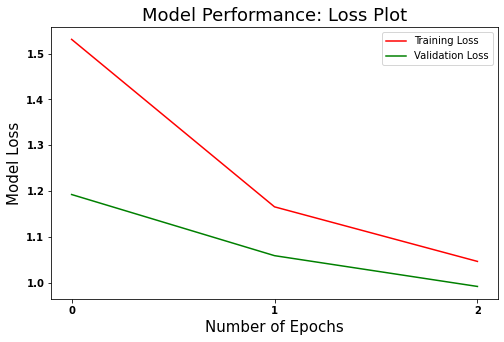

In [30]:
#Plotting the loss plot
plt.rcParams['figure.figsize']=(8,5)
plt.plot(history.history['loss'],label='Training Loss',color='red')
plt.plot(history.history['val_loss'],label='Validation Loss',color='green')
plt.xticks([0,1,2],weight='bold',fontsize=10)
plt.yticks(weight='bold',fontsize=10)
plt.xlabel('Number of Epochs',fontsize=15)
plt.ylabel('Model Loss',fontsize=15)
plt.title('Model Performance: Loss Plot',fontsize=18)
plt.savefig('BaselineLoss.jpeg',dpi=200)
plt.legend()

In [34]:
pred_train=model.predict([trdf.user_id, trdf.business_id])
pred_val=model.predict([valdf.user_id, valdf.business_id])
pred_test=model.predict([testdf.user_id, testdf.business_id])

print(f'The model performance for the train, validation and test datasets are:\n {np.round(mean_squared_error(trdf.stars,pred_train),2)},{np.round(mean_squared_error(valdf.stars,pred_val),2)},{np.round(mean_squared_error(testdf.stars,pred_test),2)}')


The model performance for the train, validation and test datasets are:
 0.93,0.99,0.99


## References

    [1] Problem 2, https://www.kaggle.com/georgeliu/problem-2 
    [2] Restaurant-Recommendation-System, https://github.com/yashrajwani/Restaurant-Recommendation-System
    [3] Recommendation Systems, https://www.univ.ai